In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.optim import Adam
import torchvision.transforms.functional as fn

import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from di_dataset import DepthImageDataset

from torch.utils.tensorboard import SummaryWriter

In [2]:
writer = SummaryWriter('runs/vae_cifar10')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2022-02-23 16:38:09.435796: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


cpu


/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


# Load Dataset

In [3]:
saves_folders = "../../../rl_data"
load_paths = [os.path.join(saves_folders, saves_folder) for saves_folder in os.listdir(saves_folders)]

In [30]:
load_path = "../../../rl_data/saves_2"

In [31]:
# Hyperparams
latent_dim = 5000 
num_epochs = 10
batch_size = 1
learning_rate = 1e-3

In [32]:
# Obtain train and test data
dataset = DepthImageDataset(load_path=load_path)

Loading from ../../../rl_data/saves_2


100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.28it/s]


In [33]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=0)
len(train_loader), len(test_loader), len(train_dataset), len(test_dataset)

(1, 1, 1, 1)

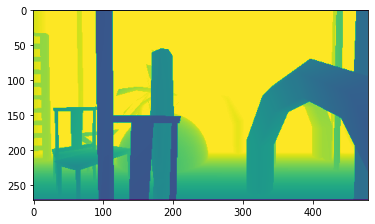

torch.Size([1, 272, 480])


In [34]:
dataiter = iter(train_loader)
image_batch = dataiter.next()

import torch.nn.functional as F


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for image in image_batch:
    imshow(image)

    
print(image.shape)

In [35]:
image_batch.squeeze().mean(), image_batch.squeeze().var()

(tensor(0.7420), tensor(0.0769))

# Define Variational Autoencoder


In [36]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        x = self.layer4(x)
        #print(f"x_enc = {x.shape}")
        x = F.adaptive_avg_pool2d(x, 1)
        #print(f"x_enc = {x.shape}")
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512
        self.nc = nc

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        #print("x before interpoloate:", x.shape)
        #x = F.interpolate(x, size=[17, 30], mode='bilinear', align_corners=True)
        x = F.interpolate(x, size=[17, 30], mode='nearest')
        #print(x.shape)
        x = self.layer4(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer1(x)
        #print("fix layer 1")
        #print(x.shape)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), self.nc, 272, 480)
        #print(x.shape)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim, nc=1):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim, nc=nc)
        self.decoder = ResNet18Dec(z_dim=z_dim, nc=nc)
    
        
    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        #print(f"z_dim = {z.shape}")
        x_hat = self.decoder(z)

        return mean, logvar, x_hat
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, sqrt is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean



# Training

In [37]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.BCELoss(reduction='sum')(x_hat, x)
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

In [38]:
n_training_samples = len(train_dataset)
n_iterations = math.ceil(n_training_samples/batch_size)
n_training_samples, n_iterations

(1, 1)

In [39]:
vae_model = VAE(z_dim=latent_dim)
optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

In [40]:
for epoch in range(num_epochs):
    overall_loss = 0
    overall_elbo = 0
    since = time.time()
    for i, image in enumerate(train_loader):

        optimiser.zero_grad()

        # VAE forward pass
        mu, logvar, x_hat = vae_model(image)

        # Loss
        loss = loss_function(image, x_hat, mu, logvar)

        overall_loss += loss

        # Update weights
        
        loss.backward()
        optimiser.step()

        if (i+1) % 1 == 0:
            time_elapsed = time.time() - since
            print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.3f}")


epoch: 1/10, step: 1/1, Avg loss: 85741.414, time: 1.135
epoch: 2/10, step: 1/1, Avg loss: 95925.328, time: 1.089
epoch: 3/10, step: 1/1, Avg loss: 94832.898, time: 0.917
epoch: 4/10, step: 1/1, Avg loss: 73507.930, time: 0.896
epoch: 5/10, step: 1/1, Avg loss: 70999.500, time: 0.963
epoch: 6/10, step: 1/1, Avg loss: 69073.586, time: 0.943
epoch: 7/10, step: 1/1, Avg loss: 68328.344, time: 0.915
epoch: 8/10, step: 1/1, Avg loss: 67959.938, time: 1.133
epoch: 9/10, step: 1/1, Avg loss: 67306.883, time: 1.002
epoch: 10/10, step: 1/1, Avg loss: 66719.031, time: 1.021


In [48]:
from torchsummary import summary
summary(vae_model, (1, 272, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 136, 240]             576
       BatchNorm2d-2         [-1, 64, 136, 240]             128
            Conv2d-3         [-1, 64, 136, 240]          36,864
       BatchNorm2d-4         [-1, 64, 136, 240]             128
            Conv2d-5         [-1, 64, 136, 240]          36,864
       BatchNorm2d-6         [-1, 64, 136, 240]             128
     BasicBlockEnc-7         [-1, 64, 136, 240]               0
            Conv2d-8         [-1, 64, 136, 240]          36,864
       BatchNorm2d-9         [-1, 64, 136, 240]             128
           Conv2d-10         [-1, 64, 136, 240]          36,864
      BatchNorm2d-11         [-1, 64, 136, 240]             128
    BasicBlockEnc-12         [-1, 64, 136, 240]               0
           Conv2d-13         [-1, 128, 68, 120]          73,728
      BatchNorm2d-14         [-1, 128, 

# Evaluation

tensor(0.7420) tensor(0.6652)
tensor(0.0769) tensor(0.0448)
torch.Size([1, 1, 272, 480])


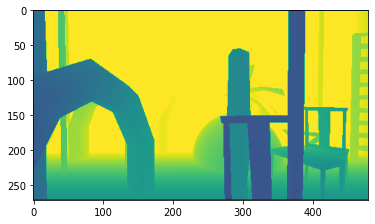

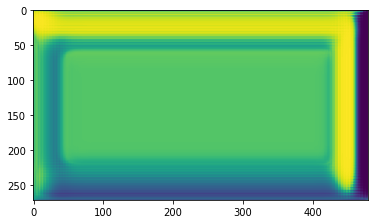

In [41]:
vae_model.eval()
# Visualise sample of images

with torch.no_grad():
    for images in test_loader:
        # VAE forward pass
        _, _, x_hat = vae_model(images)

        print(images.mean(), x_hat.mean())
        print(images.var(), x_hat.var())
        print(images.shape)
        for idx in range(len(images)):
            # show images
            imshow(images[idx])
            imshow(x_hat[idx])

        # write to tensorboard
        # writer.add_image('four_cifar10_images', inv_normalize(img_grid))


tensor(0.7420) tensor(0.6801)
tensor(0.0769) tensor(0.0402)
torch.Size([1, 1, 272, 480])


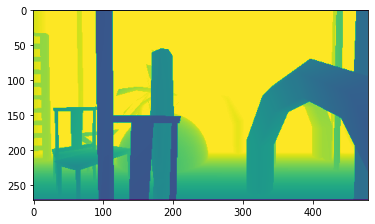

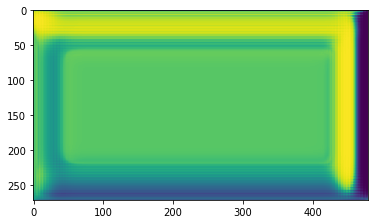

In [42]:
vae_model.eval()
# Visualise sample of images

with torch.no_grad():
    for images in train_loader:
        # VAE forward pass
        _, _, x_hat = vae_model(images)

        print(images.mean(), x_hat.mean())
        print(images.var(), x_hat.var())
        print(images.shape)
        for idx in range(len(images)):
            # show images
            imshow(images[idx])
            imshow(x_hat[idx])

        # write to tensorboard
        # writer.add_image('four_cifar10_images', inv_normalize(img_grid))
